In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
data = pd.read_csv('/home/hasan/DATA SET/stock price data.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,3.89,3.99,3.89,3.96,3.629303,12100
1,2010-01-05,3.90,4.06,3.88,3.94,3.610974,41600
2,2010-01-06,3.89,3.92,3.82,3.92,3.592642,11500
3,2010-01-07,3.96,4.04,3.93,4.04,3.702622,33700
4,2010-01-08,4.09,4.12,3.98,3.98,3.647633,13200


In [4]:
data.shape

(2598, 7)

In [5]:
#converting to datetime of Date column
data['Date'] = pd.to_datetime(data['Date'])


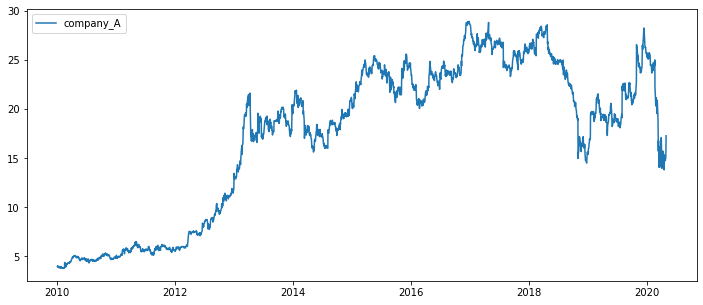

In [8]:
#original data
plt.figure(figsize=(12,5))
plt.plot(data['Date'], data['Close'], label='company_A')
plt.legend(loc='best')
plt.show()

# Simple Moving Average

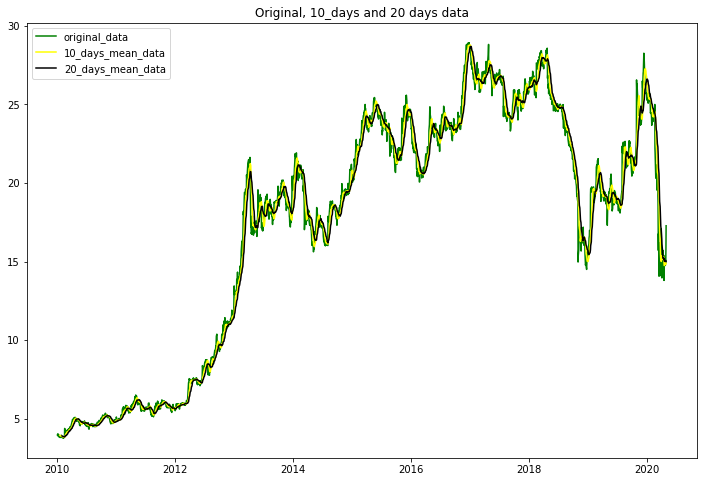

In [9]:
#predicting using Moving Average algorithm
data['10_day'] = data['Close'].rolling(10).mean().shift()  #shift so the day we want to predict won't be used
data['20_day'] = data['Close'].rolling(20).mean().shift()

#drawing figure
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['Close'], label='original_data', color='green')
plt.plot(data['Date'], data['10_day'], label='10_days_mean_data', color='yellow')
plt.plot(data['Date'], data['20_day'], label='20_days_mean_data', color='black')
plt.title('Original, 10_days and 20 days data')
plt.legend(loc='best')
plt.show()

# Exponential Moving Average

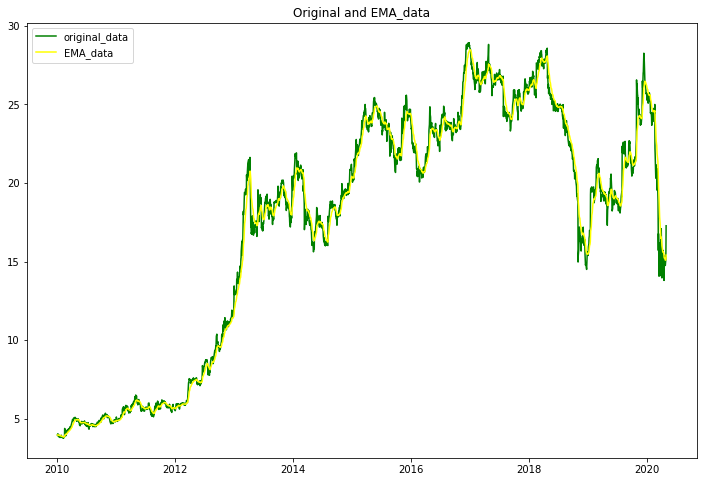

In [10]:
#predicting using Exponential Moving Average algorithm
def EMA(tw):
    for x in tw:
        data["EMA"] = data['Close'].ewm(span=x, adjust=False).mean()
EMA(data['Close'])

#drowing figure
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['Close'], label='original_data', color='green')
plt.plot(data['Date'], data['EMA'], label='EMA_data', color='yellow')
plt.title('Original and EMA_data')
plt.legend(loc='best')
plt.show()


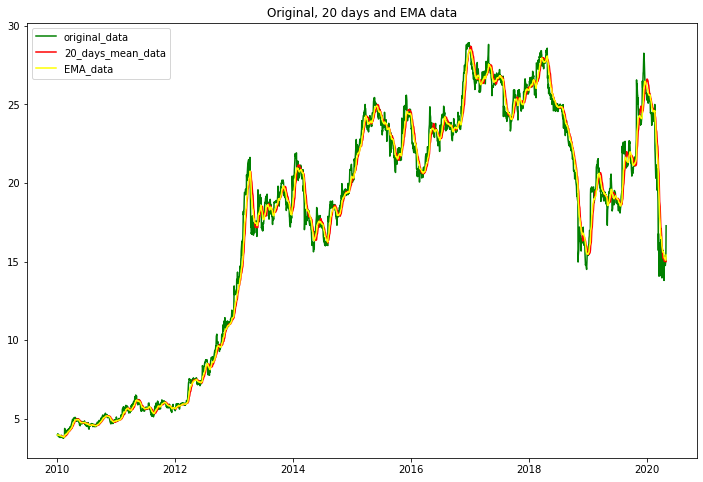

In [11]:
#drawing figure
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['Close'], label='original_data', color='green')
plt.plot(data['Date'], data['20_day'], label='20_days_mean_data', color='red')
plt.plot(data['Date'], data['EMA'], label='EMA_data', color='yellow')
plt.title('Original, 20 days and EMA data')
plt.legend(loc='best')
plt.show()

Using a slightly fancier algorithm, the Exponential Moving Average (EMA), we achieve some small improvement:

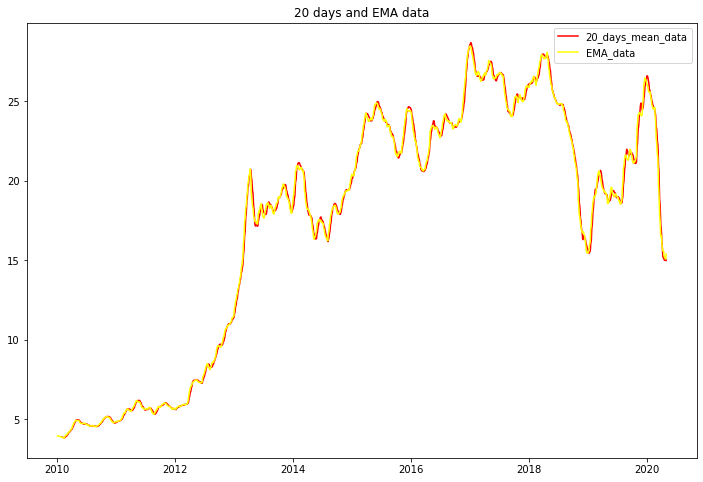

In [12]:
#drawing figure
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['20_day'], label='20_days_mean_data', color='red')
plt.plot(data['Date'], data['EMA'], label='EMA_data', color='yellow')
plt.title('20 days and EMA data')
plt.legend(loc='best')
plt.show()


# LSTM(Long Short Term Memory)

In [13]:
data = data.drop(['Open','High','Low','Adj Close','Volume','10_day','20_day','EMA'], axis=1)

In [14]:
#setting Date column as index
data.set_index(['Date'], inplace=True)
data.head()

,Close
Date,
2010-01-04,3.96
2010-01-05,3.94
2010-01-06,3.92
2010-01-07,4.04
2010-01-08,3.98


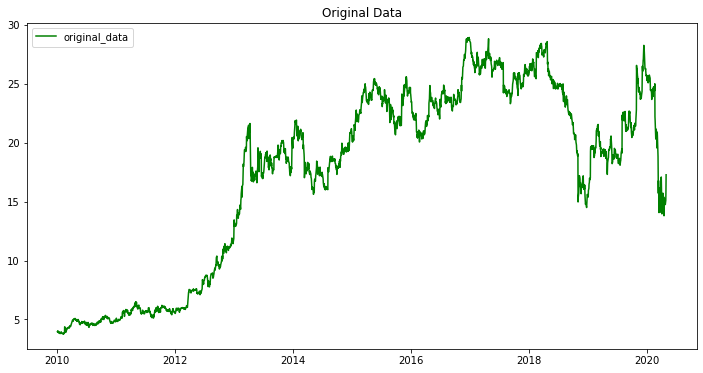

In [15]:
#original graph
plt.figure(figsize=(12,6))
plt.plot(data, label='original_data', color='green')
plt.title('Original Data')
plt.legend(loc='best')

In [16]:
look_back = 40
forward_days = 10
num_periods = 20

# data normalization

In [17]:
value = data['Close']
array = value.values.reshape(value.shape[0],1)
print(array.shape)

(2598, 1)


In [18]:
scaler = MinMaxScaler()
array = scaler.fit_transform(array)
array[:5]

array([[0.00755167],
       [0.00675676],
       [0.00596184],
       [0.01073132],
       [0.00834658]])

In [19]:
#dividing dataset to train and test
train,test = train_test_split(array, test_size=.2, random_state=0)
print('Shape of train :', train.shape)
print('Shape of test :', test.shape)


Shape of train : (2078, 1)
Shape of test : (520, 1)


In [20]:
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)


In [21]:
X_test,y_test = processData(test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

print('Shape of X_test :', X_test.shape)
print('Shape of y_test :', y_test.shape)

Shape of X_test : (48, 40, 1)
Shape of y_test : (48, 10)


In [22]:
#spliting train data for train and valid
X_train,xvalid, Y_train,yvalid = train_test_split(X,y, test_size=.25, random_state=0)
print('Shape of X_train :',X_train.shape)
print('Shape of xvalid :',xvalid.shape)
print('Shape of Y_train :',Y_train.shape)
print('Shape of yvalid :',yvalid.shape)

Shape of X_train : (1521, 40, 1)
Shape of xvalid : (508, 40, 1)
Shape of Y_train : (1521, 10)
Shape of yvalid : (508, 10)


# Model

In [23]:
model = Sequential()
model.add(LSTM(50, input_shape=(40,1), return_sequences=True))
model.add(Dropout(.3))
model.add(LSTM(30, input_shape=(50,1)))
model.add(Dropout(.5))
model.add(Dense(10))

In [24]:
#compiling the model
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [25]:
fit_history = model.fit(X_train,Y_train, batch_size=2, verbose=1,  epochs=50, shuffle=True, validation_data=(xvalid,yvalid))


Train on 1521 samples, validate on 508 samples
Epoch 1/50
1521/1521 [==============================] - 25s 17ms/step - loss: 0.1310 - val_loss: 0.1006
Epoch 2/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.1057 - val_loss: 0.0988
Epoch 3/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.1010 - val_loss: 0.0982
Epoch 4/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0998 - val_loss: 0.0974
Epoch 5/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0983 - val_loss: 0.0982
Epoch 6/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0978 - val_loss: 0.0976
Epoch 7/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0973 - val_loss: 0.0973
Epoch 8/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0971 - val_loss: 0.0975
Epoch 9/50
1521/1521 [==============================] - 23s 15ms/step - loss: 0.0970 - val_loss: 0.0975
Epoch 10/50
1521/

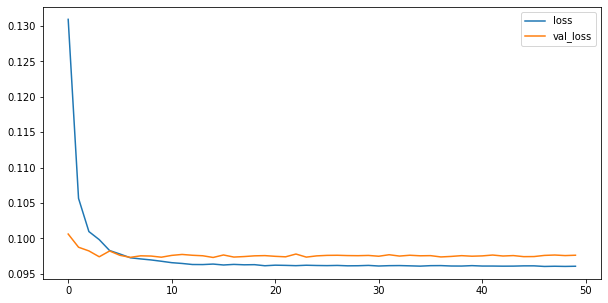

In [26]:
#graph of loss and validation loss 
plt.figure(figsize = (10,5))

plt.plot(fit_history.history['loss'], label='loss')
plt.plot(fit_history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()



In [27]:
#predicting with test data
predicted = model.predict(X_test)
predicted

array([[0.5399295 , 0.5441142 , 0.5317441 , 0.5349129 , 0.5416335 ,
        0.54185313, 0.536542  , 0.5565462 , 0.5391909 , 0.53782773],
       [0.5569646 , 0.551977  , 0.5522639 , 0.5317379 , 0.55369425,
        0.5620055 , 0.5584285 , 0.5747963 , 0.54730445, 0.5292744 ],
       [0.55678505, 0.5501464 , 0.5424274 , 0.55674726, 0.5624276 ,
        0.5612121 , 0.5417226 , 0.561682  , 0.54125696, 0.53039753],
       [0.5309734 , 0.54502153, 0.52971077, 0.53540486, 0.52796113,
        0.5164785 , 0.5205188 , 0.54476374, 0.53475744, 0.5461464 ],
       [0.5393918 , 0.5502314 , 0.5407749 , 0.53090745, 0.53208786,
        0.523866  , 0.5323531 , 0.5534857 , 0.53914255, 0.5402503 ],
       [0.5471755 , 0.55061483, 0.54029715, 0.55481356, 0.5476443 ,
        0.5352823 , 0.52728295, 0.54955643, 0.5367552 , 0.53784853],
       [0.527271  , 0.5414827 , 0.5221904 , 0.538653  , 0.5292706 ,
        0.5180644 , 0.51685274, 0.540765  , 0.5334596 , 0.5468739 ],
       [0.52422   , 0.5415905 , 0.5213189

Those are scaler data

In [50]:
#unscaled of predicted data
unscaled = scaler.inverse_transform(predicted.reshape(-1,1))
print('Shape of unscaled is :',unscaled.shape)
unscaled[:5,:]

Shape of unscaled is : (480, 1)


array([[17.354626],
       [17.459913],
       [17.148682],
       [17.228409],
       [17.3975  ]], dtype=float32)